# NLP Project
Prediction the price based on the comments

In [1]:
# Import Libraries

import os
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import re

In [2]:
# read data chunks:
reader = pd.read_csv('train_pr_sample.csv',iterator=True, header=0, encoding = "ISO-8859-1")

loop = True
chunkSize=100000
chunks = []
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        chunks.append(chunk)
    except StopIteration:
        loop = False
        print ("Iteration is stopped.")
    
df = pd.concat(chunks, ignore_index=True)

Iteration is stopped.


In [3]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
2,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...
3,13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
4,39,Victoria secret 34 c corest top,3,Women/Underwear/Bras,Victoria's Secret,10.0,0,Victoria secret 34 c corest top Will bundle to...


# Explore Data

In [4]:
# df columns
print (df.columns)

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')


In [5]:
print("Size of the DF:",df.shape)
print(df.dtypes)

Size of the DF: (118948, 8)
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


In [6]:
## modify price:
# remove rows with price less than 1
noprice=df[df['price']<1].index
df.drop(df.index[noprice],inplace=True)

In [7]:
df.apply(lambda x: x.nunique())

train_id             118891
name                 111202
item_condition_id         5
category_name           996
brand_name             2176
price                   419
shipping                  2
item_description     107475
dtype: int64

In [8]:
df.price.describe()

count    118891.000000
mean         26.669475
std          37.728794
min           3.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        1808.000000
Name: price, dtype: float64

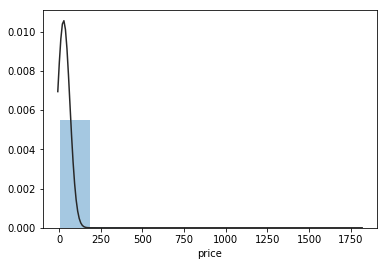

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
y=df.price
sns.distplot(y, fit=norm, bins=10, kde=False)
plt.show()

In [10]:
#applying log transformation
y = np.log(y)

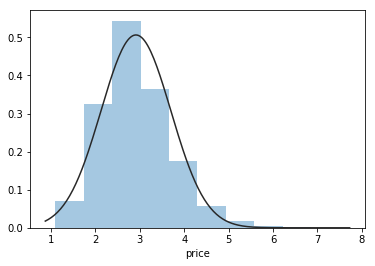

In [11]:
#transformed histogram and normal probability plot
sns.distplot(y, fit=norm,  bins=10, kde=False);
plt.show()

In [12]:
df.shipping.value_counts()/len(df)

0    0.553818
1    0.446182
Name: shipping, dtype: float64

In [13]:
df.isnull().sum()

train_id                 0
name                     0
item_condition_id        0
category_name          483
brand_name           50668
price                    0
shipping                 0
item_description        15
dtype: int64

In [14]:
df.shape

(118891, 8)

In [15]:
df.groupby(['item_condition_id'],as_index=True)['price'].mean().sort_values(ascending=False)

item_condition_id
5    31.213930
2    27.263823
1    26.518387
3    26.515295
4    24.480016
Name: price, dtype: float64

In [16]:
df.groupby(['item_condition_id'],as_index=True)['price'].max().sort_values(ascending=False)

item_condition_id
2    1808.0
1    1575.0
3    1500.0
4     459.0
5     360.0
Name: price, dtype: float64

In [17]:
df.groupby(['category_name'],as_index=True)['price'].mean().sort_values(ascending=False)

category_name
Kids/Strollers/Standard                               265.000000
Kids/Strollers/Other                                  195.000000
Electronics/Computers & Tablets/Laptops & Netbooks    189.242857
Home/Bedding/Bed in a Bag                             180.000000
Other/Musical instruments/Brass Instruments           170.000000
Sports & Outdoors/Golf/Electronics                    160.000000
Vintage & Collectibles/Bags and Purses/Handbag        150.654867
Home/Home Appliances/Air Conditioners                 132.500000
Kids/Strollers/Travel Systems                         126.200000
Women/Women's Handbags/Satchel                        123.486486
Electronics/Cameras & Photography/Digital Cameras     122.120370
Electronics/Computers & Tablets/Desktops & All-In-    115.846154
Electronics/Cell Phones & Accessories/Cell Phones      98.766714
Electronics/Cameras & Photography/Lenses & Filters     96.333333
Kids/Toys/Electronics for Kids                         92.981132
Men/Sweats 

In [18]:
df.groupby(['brand_name'],as_index=True)['price'].mean().sort_values(ascending=False)

brand_name
Sanyo                874.000000
Valentino Garavan    513.500000
Carolina Herrera     336.000000
Celine               320.400000
Mac Duggal           309.000000
MCM Worldwide        301.000000
Abbott               283.250000
Stuart Weitzman      266.222222
Moncler              259.000000
CÃ©line              246.000000
Joico                239.000000
Chloe                233.000000
David Yurman         225.187500
Yeezy                219.727273
Louis Vuitton        211.169231
Adams Golf           209.000000
Alyce Paris          200.000000
Contours             195.000000
Go Gear              184.333333
Christian Loubout    180.666667
AMD                  177.000000
RIM                  175.000000
UPPAbaby             172.000000
Mori Lee             171.000000
Tieks                170.333333
Scala                166.000000
Oscar de la Renta    163.500000
Intel                162.500000
ChloÃ©               161.000000
Filson               160.000000
                        ...  

 # Data Prepration

In [19]:
# Drop "name" column 
# "category_name" and "brand" have the information included in Name 
df=df.drop(['name'],axis=1)

In [20]:
# Set "train_id" as index
df.set_index('train_id',inplace=True)

In [21]:
# Spliting category_name into 3 categories:
# main_category, sub_category and item_type
df['main_category']=df.category_name.apply(lambda x: str(x).split('/')[0])
df['sub_category']=df.category_name.apply(lambda x: str(x).split('/')[1] if len(str(x).split('/'))>1 else None )
df['item_type']=df.category_name.apply(lambda x: x.split('/')[2] if len(str(x).split('/'))>2 else None)

In [22]:
# Drop "category_name" column 
df=df.drop(['category_name'],axis=1)

In [23]:
df.head()

,item_condition_id,brand_name,price,shipping,item_description,main_category,sub_category,item_type
train_id,,,,,,,,
0,3,NaN,10.0,1,No description yet,Men,Tops,T-shirts
8,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls
9,3,NaN,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll
13,1,Scholastic,4.0,1,No description yet,Other,Office supplies,School Supplies
39,3,Victoria's Secret,10.0,0,Victoria secret 34 c corest top Will bundle to...,Women,Underwear,Bras


In [24]:
df.groupby(['main_category'],as_index=True)['price'].mean().sort_values(ascending=False)

main_category
Electronics               35.022999
Men                       34.524984
Women                     28.727768
Vintage & Collectibles    27.095510
Home                      25.156021
Sports & Outdoors         25.092518
nan                       24.355072
Other                     20.928942
Kids                      20.531935
Beauty                    19.889051
Handmade                  18.031496
Name: price, dtype: float64

In [25]:
df.groupby(['sub_category'],as_index=True)['price'].mean().sort_values(ascending=False)

sub_category
Computers & Tablets          90.559441
Cameras & Photography        71.684713
Strollers                    70.878049
Bags and Purses              63.571150
Women's Handbags             58.812432
Golf                         49.036364
Footwear                     42.882353
TV, Audio & Surveillance     42.307590
Shoes                        41.404794
Blazers & Sport Coats        41.000000
Musical instruments          39.753425
Home Appliances              37.502488
Men's Accessories            34.666013
Safety                       33.857143
Coats & Jackets              33.568291
Car Audio, Video & GPS       33.232558
Video Games & Consoles       32.670068
Women's Accessories          31.611209
Gear                         31.552301
Furniture                    31.333333
Diapering                    30.507519
Kitchen & Dining             30.235097
Bedding                      29.576803
Cell Phones & Accessories    29.159938
Exercise                     29.007899
Dresses     

In [26]:
df.groupby(['item_type'],as_index=True)['price'].mean().sort_values(ascending=False)

item_type
Standard                             265.000000
Laptops & Netbooks                   189.242857
Bed in a Bag                         180.000000
Brass Instruments                    170.000000
Handbag                              150.654867
Air Conditioners                     132.500000
Travel Systems                       126.200000
Satchel                              123.486486
Digital Cameras                      122.120370
Desktops & All-In-                   115.846154
Cell Phones                           98.766714
Lenses & Filters                      96.333333
Electronics for Kids                  92.981132
Track & Sweat Suits                   90.666667
Consoles                              88.226866
Vacuums & Floor Care                  81.545455
Men's Golf Clubs                      80.000000
Flatware                              80.000000
Afghan                                76.000000
Wind & Woodwind Instrume              75.666667
Dress                         

# NLP functions 

Data Cleaning

In [27]:
# Data cleaning for NLP analysis
# 1) stemming remove stop 2) remove white space 3) remove number 4) keep at least two letter words 5)remove xml tags
stemmer = PorterStemmer()
english_stemmer= nltk.stem.PorterStemmer()
english_stop= get_stop_words('en')
token_pattern= r"(?u)\b\w\w+\b"

In [28]:
# use regexp to tokenize to list and then stem to get stemmed list and change to string
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed 

In [29]:
def preprocess_data(line, token_pattern=token_pattern):
    token_pattern= re.compile(token_pattern)# remove , flags = re.UNICODE | re.LOCALE
    tokens = [w.lower() for w in token_pattern.findall(line)]
    non_stopwords= [i for i in tokens if not i in english_stop]
    stemmed_words= [stemmer.stem(i) for i in non_stopwords]
    texts = [''.join(p for p in w if p not in string.punctuation) for w in stemmed_words]
    # Remove numbers
    texts = [''.join(p for p in w if p not in '0123456789') for w in texts]
    # Trim extra whitespace
    texts = [' '.join(w.split()) for w in texts]
    return texts

# TFIDF

In [30]:
# get the column we want to do tfidf on it and return tfidf sparse matrix
def tfidf(Summary):
    sentences = []
    for text in Summary:
        # print("\n", text)
        if str(text)!='nan':
            text = BeautifulSoup(text, "lxml").get_text()
            text = re.sub("[^a-zA-Z]"," ", text)
            texts=preprocess_data(text)
            sentences.append(texts)
        else:
            # print("\n", text)
            sentences.append(['descript', 'yet'])
        
    corpus = np.array(sentences)
    count_vect= CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
    description_counts= count_vect.fit_transform(corpus)
    tfidf_transformer= TfidfTransformer()
    Summary_tfidf= tfidf_transformer.fit_transform(description_counts)
    return (Summary_tfidf,count_vect)

In [31]:
# find maximum tfidf features and return list of them:
def select_max_tfidf(sparse_tfidf,count_vect):
    # creat data frame of each word and tfidf:
    docnum=list()
    word=list()
    tfidfnum=list()
    f_names=count_vect.get_feature_names()
    for doc in range(sparse_tfidf.shape[0]):
        feature_index=sparse_tfidf[doc,:].nonzero()[1]
        h_scores=zip(feature_index,[sparse_tfidf[doc,x] for x in feature_index])
        
        for w,s in [(f_names[i],s) for (i,s) in h_scores]:
            docnum.append(doc)
            word.append(w)
            tfidfnum.append(s)
    
    sparse_tfidf_rank=pd.DataFrame({'doc':docnum,'word':word,'tfidf':tfidfnum})
    sparse_tfidf_rank.sort_values(by='tfidf', ascending=False,inplace=True)
    # n max tfidf:
    n=sparse_tfidf_rank.groupby('word')['word'].count().count()
    n=int(n*0.1)
    # n word with max tfidf
    wordsrank=sparse_tfidf_rank.groupby('word')['tfidf'].mean().sort_values( ascending=False)[:n]
    words=wordsrank.index.tolist()
    del words[words=='nan']
    # n index with max tfidf
    words_index=list()
    for i in words:
        words_index.append(count_vect.vocabulary_[i])
    
    return (words_index,words) 

# Main

"item_description" feature extraction

In [32]:
# item_description tfidf
Summary = df['item_description']
descript_tfidf,vect=tfidf(Summary)
descript_tfidf_maxindex,descript_features=select_max_tfidf(descript_tfidf,vect)

C:\Users\mm\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mm\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [34]:
print(pd.DataFrame({"word":descript_features,"tfidf_maxindex":descript_tfidf_maxindex}))

      tfidf_maxindex            word
0               7680             eee
1               3915  capsulewardrob
2               1690       backetbal
3              14590    liquifuschia
4               2772           blurr
5              22716            shay
6              18569      papaerback
7              27243      valentinea
8              19274       pinkvenom
9              18853       pelotonia
10             14391        lieopold
11              6017          curlfo
12             22565         sethiou
13             21014            rejx
14              6805           digiz
15             18518             pam
16             26189       toxicroak
17             17723            nway
18              7045         dogahol
19             26964          unissu
20               559          alissa
21              7937             emz
22             21918          salena
23             10653           grwat
24             11058          hatnlo
25             14653     lizardtronn
2

I had a big problem at this section...
Memory limitation forced me use just 1000 rows out of 120000 rows :(
My next job will be dealing with big data after finishing this project

In [35]:
df=df[0:1000]

In [59]:
y=y[0:1000]

In [36]:
# item_description tfidf
Summary = df['item_description']
descript_tfidf,vect=tfidf(Summary)
descript_tfidf_maxindex,descript_features=select_max_tfidf(descript_tfidf,vect)

In [37]:
# remove indices with low tfidf:
descript_tfidf_dense=pd.DataFrame(descript_tfidf.todense(),index=df.index)  
descript_tfidf_dense=descript_tfidf_dense[descript_tfidf_maxindex]    
descript_tfidf_dense.columns=descript_features

In [38]:
descript_tfidf_dense.head()

,nwob,tween,latgr,wth,lp,fa,justic,lippi,flannel,neve,...,wallet,fli,pig,maul,chocol,ding,balm,midi,wore,sin
train_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Final DataFrame

In [39]:
# Create dummy variables for object variables:
dummy_brand_name=pd.get_dummies(df['brand_name'],prefix='brand')
dummy_main_category=pd.get_dummies(df['main_category'],prefix='main_cat')
dummy_sub_category=pd.get_dummies(df['sub_category'],prefix='sub_cat')

# dummy_table_condition=pd.get_dummies(df['item_condition_id'],prefix='condition')

In [40]:
## merge tables to create final table
finaldf=dummy_brand_name.merge(dummy_main_category, how='inner', left_index=True, right_index=True) 
finaldf=finaldf.merge(dummy_sub_category, how='inner', left_index=True, right_index=True)
finaldf=finaldf.merge(descript_tfidf_dense, how='inner', left_index=True, right_index=True)
finaldf=finaldf.merge(df['shipping'].to_frame(), how='inner', left_index=True, right_index=True)
finaldf=finaldf.merge(df['item_condition_id'].to_frame(), how='inner', left_index=True, right_index=True)
finaldf=finaldf.merge(df['price'].to_frame(), how='inner', left_index=True, right_index=True)

In [41]:
finaldf.shape

(1000, 613)

In [42]:
finaldf.columns

Index(['brand_ALEX AND ANI', 'brand_ALO Yoga', 'brand_ASUS',
       'brand_Abercrombie & Fit', 'brand_Adidas', 'brand_Air Jordan',
       'brand_American Boy & Gi', 'brand_American Eagle',
       'brand_Anastasia Beverly', 'brand_Angry Birds',
       ...
       'maul', 'chocol', 'ding', 'balm', 'midi', 'wore', 'sin', 'shipping',
       'item_condition_id', 'price'],
      dtype='object', length=613)

In [43]:
finaldf.head()

,brand_ALEX AND ANI,brand_ALO Yoga,brand_ASUS,brand_Abercrombie & Fit,brand_Adidas,brand_Air Jordan,brand_American Boy & Gi,brand_American Eagle,brand_Anastasia Beverly,brand_Angry Birds,...,maul,chocol,ding,balm,midi,wore,sin,shipping,item_condition_id,price
train_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,10.0
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,19.0
9,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,8.0
13,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,4.0
39,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,10.0


# Feature Extraction

In [44]:
# Function to find correlation between the target and features

def corr_target_variables(df,targetname):
    corr_table=pd.DataFrame([1,1],index=['Pearson','spearman'],columns=['price'])# Correlation table initial value
    num_col=df.shape[1] # number of columns
    
    omited_var=list()# list of variables which do not attend in correlation
    
    for i in range(1,num_col):
        try:
            df2=pd.DataFrame({'target':df[targetname],df.columns[i]:df[df.columns[i]]})
            corr=pd.DataFrame([df2.corr(method='pearson')['target'][df.columns[i]],df2.corr(method='spearman')['target'][df.columns[i]]],
                      index=['Pearson','spearman'],columns=[df.columns[i]])
            corr_table=corr_table.merge(corr, how='inner', left_index=True, right_index=True)
        except:
            omited_var.append(df.columns[i])
            pass
    return corr_table

In [45]:
corr_table=corr_target_variables(finaldf, 'price')

In [46]:
corr_table

,price_x,brand_ALO Yoga,brand_ASUS,brand_Abercrombie & Fit,brand_Adidas,brand_Air Jordan,brand_American Boy & Gi,brand_American Eagle,brand_Anastasia Beverly,brand_Angry Birds,...,maul,chocol,ding,balm,midi,wore,sin,shipping,item_condition_id,price_y
Pearson,1,-0.013089,0.051510,-0.010636,0.014220,0.048239,-0.000009,-0.011006,-0.011454,-0.015543,...,0.105478,-0.000824,0.027523,-0.017378,-0.010574,-0.020612,0.001629,-0.120076,-0.008970,1.0
spearman,1,-0.029389,0.051267,-0.016120,0.072816,0.050938,0.030567,0.015553,-0.020562,-0.045235,...,0.053789,0.020726,0.056929,-0.034417,-0.003013,-0.025574,0.025441,-0.281615,-0.010093,1.0


In [112]:
corr_table=corr_table.abs()
max_corr=corr_table.max()
max_corr.sort_values(ascending=False,inplace=True)
max_corr=max_corr[max_corr>0.12]
# extract 100 features in model_table
last_cols=max_corr.index.tolist()

In [113]:
print(max_corr)

price_y                          1.000000
price_x                          1.000000
patina                           0.591197
honey                            0.368339
brand_Louis Vuitton              0.366710
brand_YSL Yves Saint La          0.363056
shipping                         0.281615
brand_Canon                      0.264931
sub_cat_Cameras & Photography    0.264931
sub_cat_Women's Handbags         0.219585
sub_cat_Shoes                    0.185171
brand_Michael Kors               0.146540
main_cat_Men                     0.134598
brand_Nike                       0.120463
dtype: float64


In [114]:
del last_cols[:2]
model_table=finaldf[last_cols]

In [115]:
model_table.head()

,patina,honey,brand_Louis Vuitton,brand_YSL Yves Saint La,shipping,brand_Canon,sub_cat_Cameras & Photography,sub_cat_Women's Handbags,sub_cat_Shoes,brand_Michael Kors,main_cat_Men,brand_Nike
train_id,,,,,,,,,,,,
0,0.0,0.0,0,0,1,0,0,0,0,0,1,0
8,0.0,0.0,0,0,0,0,0,0,0,0,0,1
9,0.0,0.0,0,0,0,0,0,0,0,0,0,0
13,0.0,0.0,0,0,1,0,0,0,0,0,0,0
39,0.0,0.0,0,0,0,0,0,0,0,0,0,0


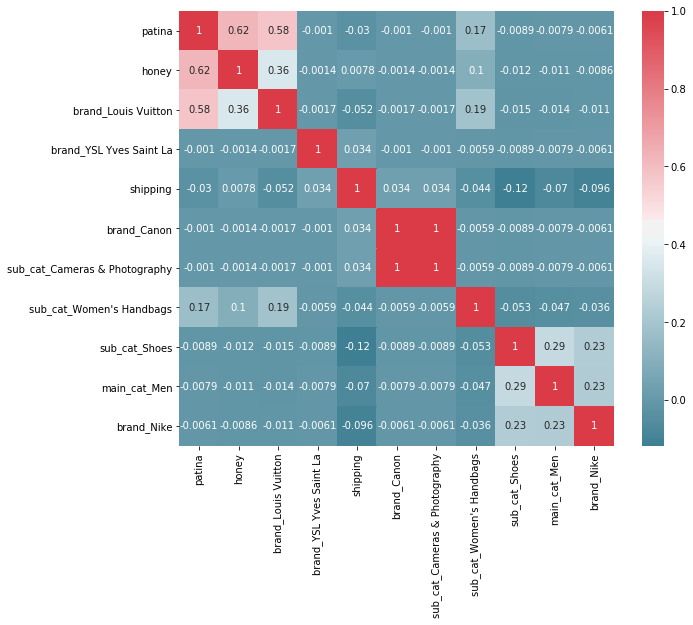

In [123]:
fn, ax = plt.subplots(figsize=(10, 8))
corr = model_table.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

In [117]:
highCor=abs(corr.unstack()).sort_values(ascending=False)[len(last_cols)::2]

In [118]:
highCor

brand_Michael Kors             brand_Michael Kors               1.000000
patina                         honey                            0.622263
brand_Louis Vuitton            patina                           0.576772
                               honey                            0.357997
main_cat_Men                   sub_cat_Shoes                    0.292179
sub_cat_Shoes                  brand_Nike                       0.234664
main_cat_Men                   brand_Nike                       0.227631
sub_cat_Women's Handbags       brand_Louis Vuitton              0.191496
brand_Michael Kors             sub_cat_Women's Handbags         0.182028
patina                         sub_cat_Women's Handbags         0.168642
shipping                       sub_cat_Shoes                    0.117372
sub_cat_Women's Handbags       honey                            0.100425
brand_Nike                     shipping                         0.095562
main_cat_Men                   shipping            

In [119]:
highCorrList=list(set(list(highCor[highCor>0.75].unstack().index)+list(highCor[highCor>0.75].unstack().columns.values)))

print(highCorrList)

['brand_Michael Kors']


In [120]:
DropList=max_corr[highCorrList][max_corr[highCorrList]<0.65]
DropList=list(DropList.index)
print(DropList)

['brand_Michael Kors']


In [121]:
model_table.drop(DropList,axis=1,inplace=True)

C:\Users\mm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [124]:
model_table.columns

Index(['patina', 'honey', 'brand_Louis Vuitton', 'brand_YSL Yves Saint La',
       'shipping', 'brand_Canon', 'sub_cat_Cameras & Photography',
       'sub_cat_Women's Handbags', 'sub_cat_Shoes', 'main_cat_Men',
       'brand_Nike'],
      dtype='object')

In [125]:
model_table.dtypes

patina                           float64
honey                            float64
brand_Louis Vuitton                uint8
brand_YSL Yves Saint La            uint8
shipping                           int64
brand_Canon                        uint8
sub_cat_Cameras & Photography      uint8
sub_cat_Women's Handbags           uint8
sub_cat_Shoes                      uint8
main_cat_Men                       uint8
brand_Nike                         uint8
dtype: object

# ML model: Linear Regression

In [127]:
from sklearn.model_selection import train_test_split
#split data to test and train
x_train,x_test = train_test_split(model_table, random_state=233, train_size=0.75)
y_train,y_test= train_test_split(y, random_state=233, train_size=0.75)

C:\Users\mm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [128]:
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn import linear_model
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(x_train, y_train)

# The intercept and coefficients, mean-squared error, R-squared score
print(' Intercept & Coefficients: \n', regr.intercept_, regr.coef_)
print("Mean squared error (training): %.2f" % mean_squared_error(y_train, regr.predict(x_train)))
print("Mean squared error (testing): %.2f" % mean_squared_error(y_test, y_pred))
print('R-square score (training): %.2f' % regr.score(x_train, y_train))
print('R-square score (testing): %.2f' % r2_score(y_test, y_pred))


 Intercept & Coefficients: 
 2.9902710895 [  3.00831421e+00   2.83926864e+00   6.74521229e-01  -1.55431223e-15
  -3.84207908e-01   1.62593499e+00   1.62593499e+00   5.23631751e-01
   3.98850310e-01   1.51809394e-01   1.59914946e-01]
Mean squared error (training): 0.48
Mean squared error (testing): 0.51
R-square score (training): 0.17
R-square score (testing): 0.24


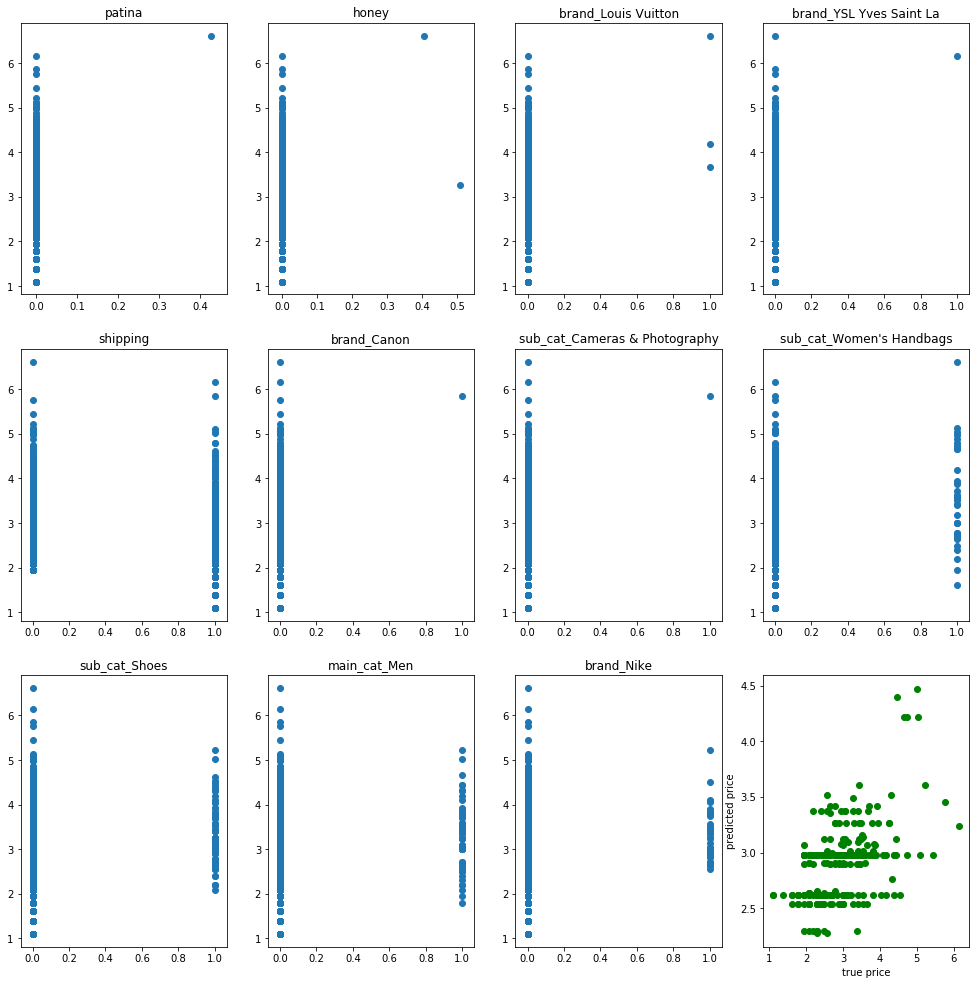

In [129]:
plt.scatter(y_test,y_pred,color='g')
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.show()

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

X=x_train
y=y_train
y = np.ravel(y)
features=X.columns.values
results=[]

lr=LinearRegression()
for i in range(1,9):
    selector=RFE(lr,n_features_to_select=i, step=1)
    selector.fit(X,y)
    r2=selector.score(X, y)
    selected_features=features[selector.support_]
    msr=mean_squared_error(y, selector.predict(X))
    results.append([i,r2,msr,",".join(selected_features)])
    
results=pd.DataFrame(results,columns=['no_features','r2','mean square error','selected_features']) 

In [135]:
results

,no_features,r2,mean square error,selected_features
0,1,0.032049,0.565391,patina
1,2,0.032049,0.565391,"patina,honey"
2,3,0.052466,0.553465,"patina,honey,sub_cat_Cameras & Photography"
3,4,0.052466,0.553465,"patina,honey,brand_Canon,sub_cat_Cameras & Pho..."
4,5,0.057622,0.550453,"patina,honey,brand_Louis Vuitton,brand_Canon,s..."
5,6,0.092100,0.530314,"patina,honey,brand_Louis Vuitton,brand_Canon,s..."
6,7,0.107068,0.521571,"patina,honey,brand_Louis Vuitton,brand_Canon,s..."
7,8,0.170638,0.484439,"patina,honey,brand_Louis Vuitton,shipping,bran..."


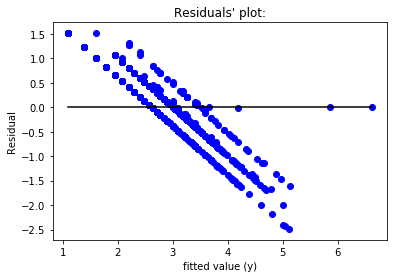

In [136]:
plt.scatter(y, selector.predict(X)-y,  color='blue')
plt.plot([y.min(),y.max()],[0,0],color='black')
plt.title("Residuals' plot:")
plt.xlabel('fitted value (y)')
plt.ylabel('Residual')
plt.show()